# SMT Solver Comparative Analysis

All solvers have their available memory limited to 4GB. They are all given the same timeout value (the time limit for each check-sat). They are all given the same 25 test files. The test files are in the form of SMT2 files containing non-linear integer equations. Files are divided into 3 groups: problems involving 1 constant, problems involving 2 constants and problems involving 3 constants. Each of these groups contain sub-groups of quadratic and cubic problems. There is a mixture of both satisfiable and unsatisfiable equations. There is a slight bias for the frequency of unsatisfiable cubic equations as these were found to be the most demanding equations, thus making them especially suitable for testing performance.


In [2]:
import resource
import time
import csv
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import crt_solver as crt_solver
import cvc5_solver as cvc5_solver
import z3_solver as z3_solver


In [3]:
# Set root directory for robust file paths
# CRTSolver -> main -> comparative_analysis.ipynb
ROOT = Path().resolve().parent

# Set absolute paths from root directory
TESTS = ROOT / "main" / "tests"
RESULTS = ROOT / "main" / "results"


In [4]:
def generate_cactus_plot(solvers, memory, timeout):
    # Set size and layout
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.tight_layout()

    # Set title and labels
    plt.title(f"Speed of SMT Solvers with Non-Linear Integer Equations ({memory}GB, {timeout}s)")
    plt.xlabel("Problems solved (count)")
    plt.ylabel("Runtime (seconds)")

    for solver in solvers:
        update_cactus_plot(solver.get_solver_name())

    # Display final cactus plot
    plt.legend()
    plt.show()

def update_cactus_plot(solver_name):
    # Populate pandas dataframe with results stored in csv file
    # Header row is automatically handled by pandas
    file_name = RESULTS / f"results_{solver_name}.csv"
    df = pd.read_csv(file_name)
    
    # Drop last row from results.csv (contains summary data)
    df = df[:-1]

    # Convert all data in runtime column to float for error-proofing
    runtimes = df["Runtime (s)"].astype(float)

    # Accumulate individual runtimes
    cumulative_runtimes = runtimes.cumsum()

    # Plot test number input (x) against cumulative runtime (y)
    if solver_name == "CRTSolver (Integer Mode)":
        plt.plot(range(1, len(cumulative_runtimes) + 1), cumulative_runtimes,
            marker="+", linestyle="-", color="tab:blue", label=solver_name)
    elif solver_name == "CRTSolver (Bit-Vector Mode)":
        plt.plot(range(1, len(cumulative_runtimes) + 1), cumulative_runtimes,
            marker="*", linestyle="-", color="tab:red", label=solver_name)
    elif solver_name == "cvc5":
        plt.plot(range(1, len(cumulative_runtimes) + 1), cumulative_runtimes,
            marker="x", linestyle="-", color="tab:green", label=solver_name)
    elif solver_name == "Z3":
        plt.plot(range(1, len(cumulative_runtimes) + 1), cumulative_runtimes,
            marker="^", linestyle="-", color="tab:orange", label=solver_name)
    

In [5]:
def generate_bar_chart(solvers, memory, timeout):
    # Set size and layout
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.tight_layout()

    # Set title and labels
    plt.title(f"Accuracy of SMT Solvers with Non-Linear Integer Equations ({memory}GB, {timeout}s)")
    plt.xlabel("SMT Solver")
    plt.ylabel("Accuracy (%)")

    solver_names = []
    accuracies = []
    for solver in solvers:
        solver_name = solver.get_solver_name()
        accuracy = calculate_accuracy(solver_name)
        solver_names.append(solver_name)
        accuracies.append(accuracy)

    # Return positions of solvers
    x_positions = range(len(solver_names))

    # Create bar chart
    if len(x_positions) == 3:
        plt.bar(x_positions, accuracies, width=0.5, color=["tab:red", "tab:green", "tab:orange"])
    else:
        plt.bar(x_positions, accuracies, width=0.5, color=["tab:blue", "tab:red", "tab:green", "tab:orange"])

    # Label positions with solver names
    plt.xticks(x_positions, solver_names)
    plt.show()

def calculate_accuracy(solver_name):
    file_name = RESULTS / f"results_{solver_name}.csv"
    total_count = 0
    unknown_count = 0

    with open(file_name, newline="") as file:
        reader = csv.reader(file)
        rows = list(reader) # return list of rows
        for row in rows[1:-1]: # exclude first and last rows
            if row:
                model = row[5]
                total_count += 1
                if "UNKNOWN (TIMEOUT)" in model or "UNKNOWN (ERROR)" in model:
                    unknown_count += 1

    accuracy = ((total_count - unknown_count) / total_count) * 100
    return accuracy


In [6]:
def execute_comparison(memory, timeout, use_crt_int):
    # Set control variables
    CHECK_SAT_TLIMIT = timeout # time limit for each check-sat call across all solvers
    MEM_LIMIT = memory # memory limit across all solvers
    timeout_s = int(timeout) / 1000

    # Instantiate solver classes
    solvers = []

    if use_crt_int:
        crtINT = crt_solver.CRTSolver(False, CHECK_SAT_TLIMIT, "CRTSolver (Integer Mode)")
        solvers.append(crtINT)

    crtBV = crt_solver.CRTSolver(True, CHECK_SAT_TLIMIT, "CRTSolver (Bit-Vector Mode)")
    solvers.append(crtBV)
    cvc5 = cvc5_solver.cvc5Solver(CHECK_SAT_TLIMIT, "cvc5")
    solvers.append(cvc5)
    z3 = z3_solver.Z3Solver(CHECK_SAT_TLIMIT, "Z3")
    solvers.append(z3)

    # Execute solvers
    for solver in solvers:
        execute_solver(solver, MEM_LIMIT)

    # Generate cactus plot for speed comparisons
    generate_cactus_plot(solvers, MEM_LIMIT, timeout_s)

    # Generate bar chart for accuracy comparisons
    generate_bar_chart(solvers, MEM_LIMIT, timeout_s)

def execute_solver(solver, memory):
    solver_name = solver.get_solver_name()

    # Set memory limit
    set_memory_limit(memory)
    print(f"Executing {solver_name} with {memory}GB memory")
    
    try:
        start_time = time.time()
        solver.execute()
        duration = time.time() - start_time
        print(f"Completed solving in {duration}s")
    except MemoryError as e:
        print(f"Stopping execution due to MemoryError: exceeded memory limit of {memory}GB")

def set_memory_limit(gb):
    # Raising memory limit requires restarting the session

    # Convert gigabytes to bytes
    # 1gb = 1024^3 bytes
    GIGABYTE = 1024 ** 3
    max_memory = int(gb * GIGABYTE) # resource.setrlimit needs integers

    # Set new memory limits - soft and hard limits are set to same value
    # Soft limit = currently allocated, hard limit = maximum allocable
    resource.setrlimit(resource.RLIMIT_AS, (max_memory, max_memory))


Executing CRTSolver (Bit-Vector Mode) with 4GB memory
Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/theater.smt2
Attempting to solve with mod 2
Retrieving candidates for mod 2
x: 0
Attempting to solve with candidates:
x: 0
Candidate UNSAT
Attempting to solve with candidates:
x: (- 2)
Candidate UNSAT
Attempting to solve with candidates:
x: 2
Candidate UNSAT
Attempting to solve with candidates:
x: (- 4)
Candidate UNSAT
Attempting to solve with candidates:
x: 4
Candidate UNSAT
Attempting to solve with mod 3
Retrieving candidates for mod 3
x: 0
Attempting to solve with candidates:
x: 0
Candidate UNSAT
Attempting to solve with candidates:
x: (- 3)
Candidate UNSAT
Attempting to solve with candidates:
x: 3
Candidate UNSAT
Attempting to solve with candidates:
x: (- 6)
Candidate UNSAT
Attempting to solve with candidates:
x: 6
Candidate UNSAT
Attempting to solve with mod 5
Retrieving candidates for mod 5
x: 4
Attempting to solve with candidates:
x: 24
Candidate UNSAT
Attempting to sol

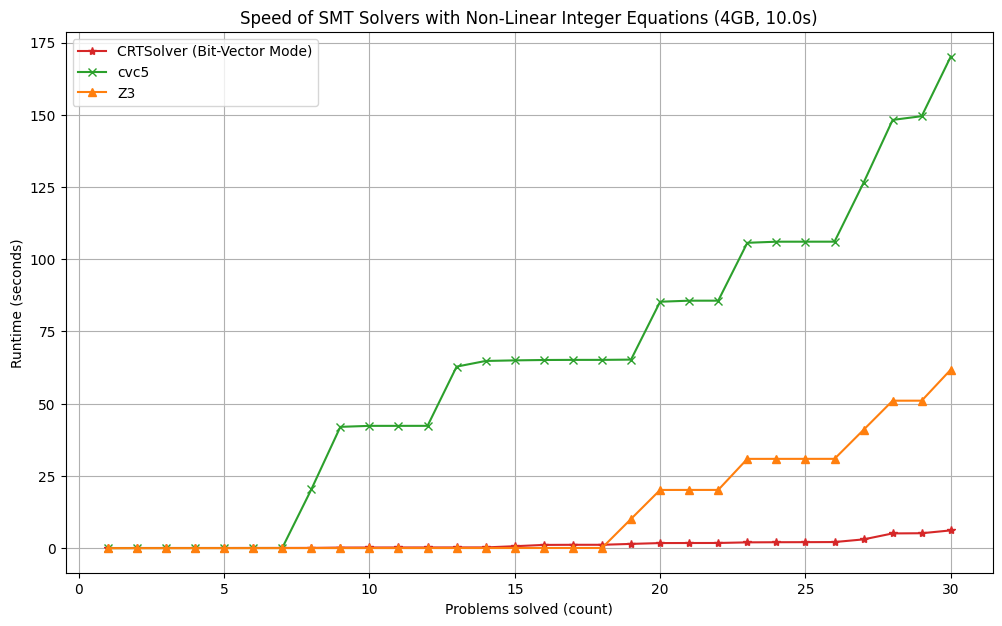

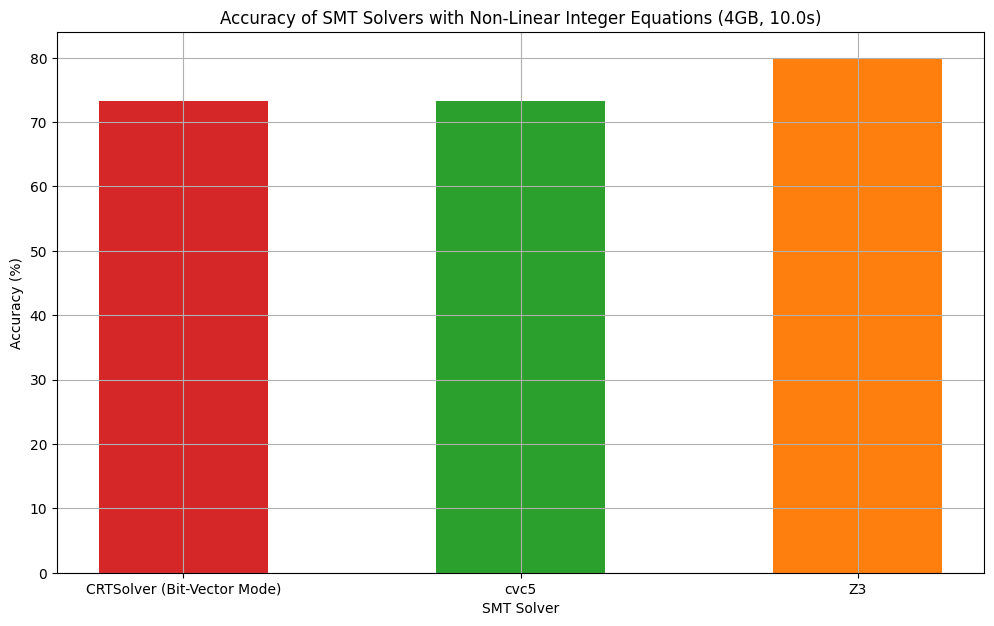

In [8]:
# Compare with 4GB memory and 30 seconds timeout
execute_comparison(4, "10000", False)


Executing CRTSolver (Bit-Vector Mode) with 4GB memory
Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/theater.smt2
Attempting to solve with mod 2
UNKNOWN (TIMEOUT)

Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/cat.smt2
Attempting to solve with mod 2
UNKNOWN (TIMEOUT)

Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/dog.smt2
Attempting to solve with mod 2
UNKNOWN (TIMEOUT)

Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/house.smt2
Attempting to solve with mod 2
UNSAT

Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/elephant.smt2
Attempting to solve with mod 2
UNKNOWN (TIMEOUT)

Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/squirrel.smt2
Attempting to solve with mod 2
UNKNOWN (TIMEOUT)

Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/rabbit.smt2
Attempting to solve with mod 2
Retrieving candidates for mod 2
x: 1
Attempting to solve with candidates:
x: 1
Candidate UNSAT
Attempting to solve with candidates:
x: (- 1)
Candi

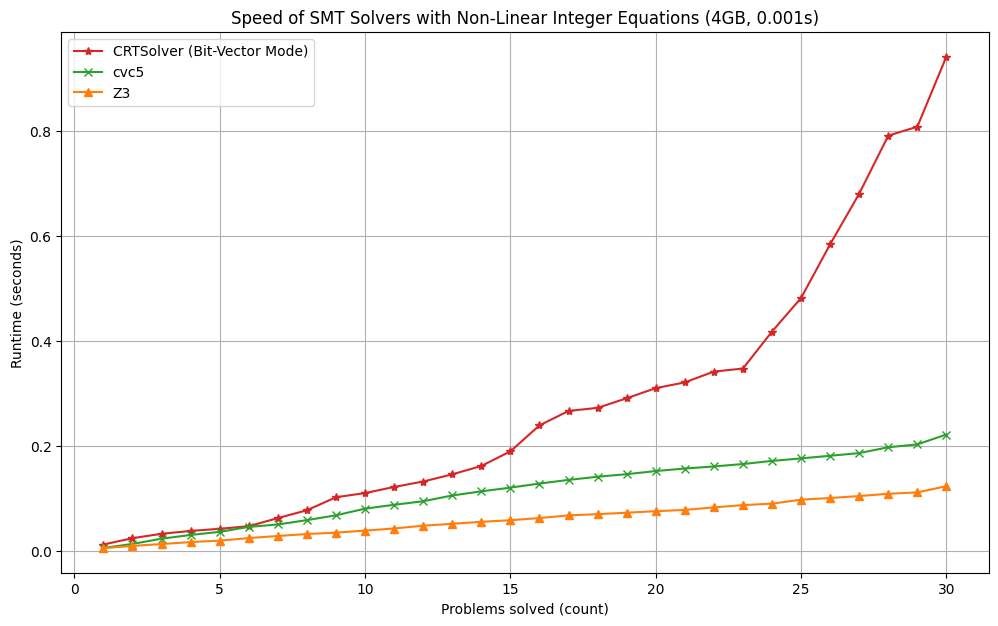

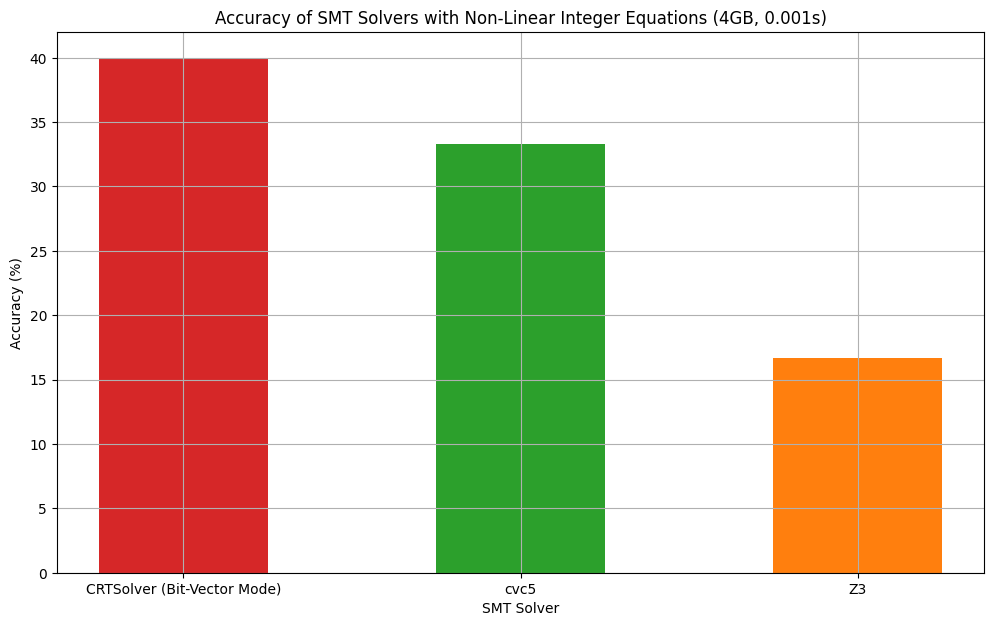

In [ ]:
# Compare with 4GB memory and 10 seconds timeout
execute_comparison(4, "1", False)

Executing CRTSolver (Bit-Vector Mode) with 4GB memory
Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/theater.smt2
Attempting to solve with mod 2
Retrieving candidates for mod 2
x: 0
Attempting to solve with candidates:
x: 0
Candidate UNSAT
Attempting to solve with candidates:
x: (- 2)
Candidate UNSAT
Attempting to solve with candidates:
x: 2
Candidate UNSAT
Attempting to solve with candidates:
x: (- 4)
Candidate UNSAT
Attempting to solve with candidates:
x: 4
Candidate UNSAT
Attempting to solve with mod 3
UNKNOWN (TIMEOUT)

Reading file: /home/matvm/CRTSolver/main/tests/1var/2deg/cat.smt2
Attempting to solve with mod 2
Retrieving candidates for mod 2
x: 0
Attempting to solve with candidates:
x: 0
Candidate UNSAT
Attempting to solve with candidates:
x: (- 2)
Candidate UNSAT
Attempting to solve with candidates:
x: 2
Candidate UNSAT
Attempting to solve with candidates:
x: (- 4)
Candidate UNSAT
Attempting to solve with candidates:
x: 4
Candidate UNSAT
Attempting to solve with mod

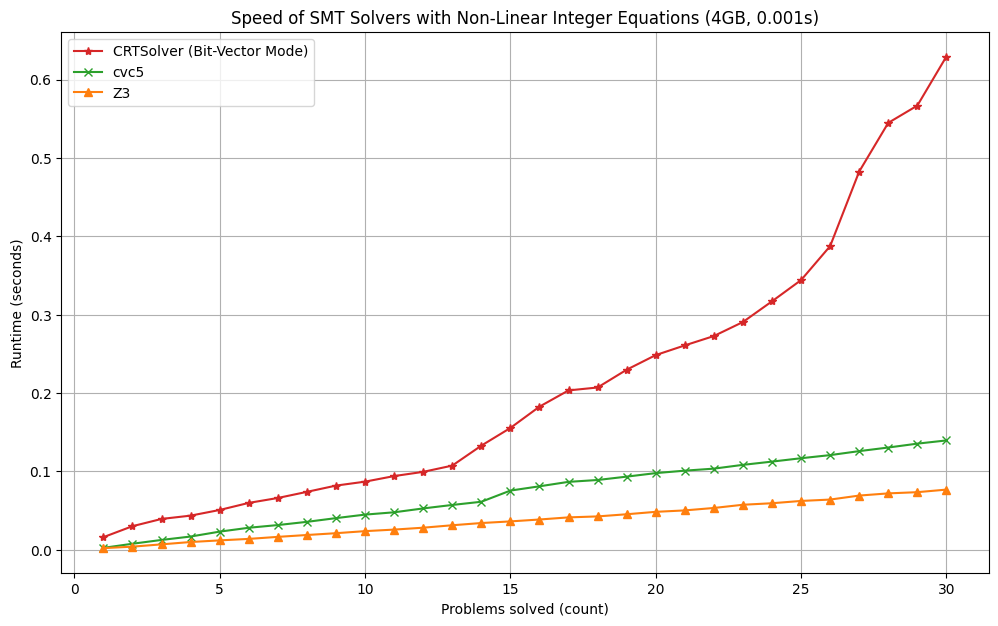

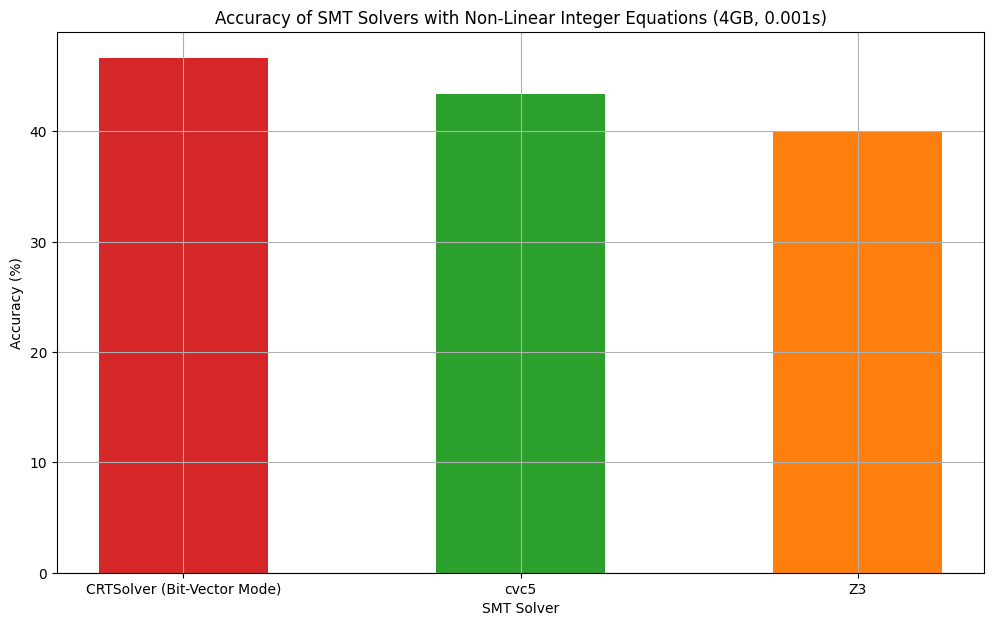

In [ ]:
# Compare with 4GB memory and 5 seconds timeout
execute_comparison(4, "1", False)